#Import dan Download Semua Package

In [1]:
import os
import pandas as pd
import nltk, os, re, string
from keras.layers import Input, LSTM, Bidirectional, SpatialDropout1D, Dropout, Flatten, Dense, Embedding, BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

#Fetch Dataset dari Kaggle

In [2]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle datasets download -d gpreda/covid-world-vaccination-progress

df = pd.read_csv('country_vaccinations.csv')
df.head(10)


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /content. Or use the environment method.


,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,0.00,0.00,NaN,NaN,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
5,Afghanistan,AFG,2021-02-27,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
6,Afghanistan,AFG,2021-02-28,8200.0,8200.0,NaN,NaN,1367.0,0.02,0.02,NaN,35.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
7,Afghanistan,AFG,2021-03-01,NaN,NaN,NaN,NaN,1580.0,NaN,NaN,NaN,41.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
8,Afghanistan,AFG,2021-03-02,NaN,NaN,NaN,NaN,1794.0,NaN,NaN,NaN,46.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
9,Afghanistan,AFG,2021-03-03,NaN,NaN,NaN,NaN,2008.0,NaN,NaN,NaN,52.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/


#Daftar Nama Kolom

In [3]:
df.columns

Index(['country', 'iso_code', 'date', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated',
       'daily_vaccinations_raw', 'daily_vaccinations',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'daily_vaccinations_per_million',
       'vaccines', 'source_name', 'source_website'],
      dtype='object')

#Daftar Negara

In [4]:
df.country.value_counts()


Latvia                             255
Norway                             254
Scotland                           250
England                            250
Wales                              245
                                  ... 
Tokelau                             43
Haiti                               27
Turkmenistan                         1
Bonaire Sint Eustatius and Saba      1
Tanzania                             1
Name: country, Length: 222, dtype: int64

#Daftar Vaksin

In [5]:
df.vaccines.value_counts()

Oxford/AstraZeneca                                                5623
Johnson&Johnson, Moderna, Oxford/AstraZeneca, Pfizer/BioNTech     4748
Moderna, Oxford/AstraZeneca, Pfizer/BioNTech                      3379
Oxford/AstraZeneca, Sinopharm/Beijing                             2615
Oxford/AstraZeneca, Pfizer/BioNTech                               2043
                                                                  ... 
Moderna, Oxford/AstraZeneca, Sinovac                                95
Abdala, Soberana02                                                  87
Covaxin, Oxford/AstraZeneca                                         86
Johnson&Johnson                                                      1
EpiVacCorona, Oxford/AstraZeneca, Sinopharm/Beijing, Sputnik V       1
Name: vaccines, Length: 65, dtype: int64

In [6]:
df_new = df.drop(columns=[
                          'iso_code', 'total_vaccinations', 'people_vaccinated', 
                          'people_fully_vaccinated', 'daily_vaccinations_raw', 
                          'daily_vaccinations', 'total_vaccinations_per_hundred', 
                          'people_vaccinated_per_hundred', 
                          'people_fully_vaccinated_per_hundred', 
                          'daily_vaccinations_per_million'
                          ])
df_new

,country,date,vaccines,source_name,source_website
0,Afghanistan,2021-02-22,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
1,Afghanistan,2021-02-23,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
2,Afghanistan,2021-02-24,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
3,Afghanistan,2021-02-25,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
4,Afghanistan,2021-02-26,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
...,...,...,...,...,...
37772,Zimbabwe,2021-08-11,"Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...",Ministry of Health,https://www.arcgis.com/home/webmap/viewer.html...
37773,Zimbabwe,2021-08-12,"Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...",Ministry of Health,https://www.arcgis.com/home/webmap/viewer.html...
37774,Zimbabwe,2021-08-13,"Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...",Ministry of Health,https://www.arcgis.com/home/webmap/viewer.html...
37775,Zimbabwe,2021-08-14,"Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...",Ministry of Health,https://www.arcgis.com/home/webmap/viewer.html...


#Total Data

In [7]:
df.shape

(37777, 15)

#Info Data

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37777 entries, 0 to 37776
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   country                              37777 non-null  object 
 1   iso_code                             37777 non-null  object 
 2   date                                 37777 non-null  object 
 3   total_vaccinations                   20874 non-null  float64
 4   people_vaccinated                    19948 non-null  float64
 5   people_fully_vaccinated              17069 non-null  float64
 6   daily_vaccinations_raw               17172 non-null  float64
 7   daily_vaccinations                   37532 non-null  float64
 8   total_vaccinations_per_hundred       20874 non-null  float64
 9   people_vaccinated_per_hundred        19948 non-null  float64
 10  people_fully_vaccinated_per_hundred  17069 non-null  float64
 11  daily_vaccinations_per_milli

#Memberikan Jumlah Kolom-Nilai yang Hilang

In [9]:
df.isnull().sum()

country                                    0
iso_code                                   0
date                                       0
total_vaccinations                     16903
people_vaccinated                      17829
people_fully_vaccinated                20708
daily_vaccinations_raw                 20605
daily_vaccinations                       245
total_vaccinations_per_hundred         16903
people_vaccinated_per_hundred          17829
people_fully_vaccinated_per_hundred    20708
daily_vaccinations_per_million           245
vaccines                                   0
source_name                                0
source_website                             0
dtype: int64

#Tabel Data Datetime

In [10]:
df['date']=pd.to_datetime(df['date'])
df['date'].head()
df['daily_vaccinations'].fillna(df['daily_vaccinations'].mean(), inplace=True) # we will fill the null row
df = df[['date','daily_vaccinations' ]]
df.head()

,date,daily_vaccinations
0,2021-02-22,125156.107029
1,2021-02-23,1367.000000
2,2021-02-24,1367.000000
3,2021-02-25,1367.000000
4,2021-02-26,1367.000000


#Download wordnet dan stopwords

In [11]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#Menghapus functuation

In [12]:
def cleaner(data):
    return(data.translate(str.maketrans('','', string.punctuation)))
    df_new.country = df_new.country.apply(lambda x: cleaner(x))
    df_new.date = df_new.date.apply(lambda x: lem(x))
    df_new.vaccines = df_new.vaccines.apply(lambda x: lem(x))
    df_new.source_name = df_new.source_name.apply(lambda x: lem(x))
    df_new.source_website = df_new.source_website.apply(lambda x: lem(x))

#Lematization

In [13]:
lemmatizer = WordNetLemmatizer()
def lem(data):
    pos_dict = {'N': wn.NOUN, 'V': wn.VERB, 'J': wn.ADJ, 'R': wn.ADV}
    return(' '.join([lemmatizer.lemmatize(w,pos_dict.get(t, wn.NOUN)) for w,t in nltk.pos_tag(data.split())]))
    df_new.country = df_new.country.apply(lambda x: lem(x))
    df_new.date = df_new.date.apply(lambda x: lem(x))
    df_new.vaccines = df_new.vaccines.apply(lambda x: lem(x))
    df_new.source_name = df_new.source_name.apply(lambda x: lem(x))
    df_new.source_website = df_new.source_website.apply(lambda x: lem(x))

#Menghapus Angka

In [14]:
def rem_numbers(data):
    return re.sub('[0-9]+','',data)
    df_new['country'].apply(rem_numbers)
    df_new['date'].apply(rem_numbers)
    df_new['vaccines'].apply(rem_numbers)
    df_new['source_name'].apply(rem_numbers)
    df_new['source_website'].apply(rem_numbers)

#Menghapus Stopword

In [15]:
st_words = stopwords.words()
def stopword(data):
    return(' '.join([w for w in data.split() if w not in st_words ]))
    df_new.country = df_new.country.apply(lambda x: stopword(x))
    df_new.date = df_new.date.apply(lambda x: lem(x))
    df_new.vaccines = df_new.vaccines.apply(lambda x: lem(x))
    df_new.source_name = df_new.source_name.apply(lambda x: lem(x))
    df_new.source_website = df_new.source_website.apply(lambda x: lem(x))

#Menampilkan Data Setelah Cleansing

In [16]:
df_new.head(10)

,country,date,vaccines,source_name,source_website
0,Afghanistan,2021-02-22,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
1,Afghanistan,2021-02-23,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
2,Afghanistan,2021-02-24,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
3,Afghanistan,2021-02-25,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
4,Afghanistan,2021-02-26,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
5,Afghanistan,2021-02-27,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
6,Afghanistan,2021-02-28,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
7,Afghanistan,2021-03-01,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
8,Afghanistan,2021-03-02,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
9,Afghanistan,2021-03-03,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/


#Menampilkan Tabel untuk Model dan Plot (Time Series)

In [17]:
delhi=df[['date','daily_vaccinations']].copy()
delhi['just_date'] = delhi['date'].dt.date
delhifinal=delhi.drop('date',axis=1)
delhifinal.set_index('just_date', inplace= True)
delhifinal.head()

,daily_vaccinations
just_date,
2021-02-22,125156.107029
2021-02-23,1367.000000
2021-02-24,1367.000000
2021-02-25,1367.000000
2021-02-26,1367.000000


In [18]:
delhifinal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37777 entries, 2021-02-22 to 2021-08-15
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   daily_vaccinations  37777 non-null  float64
dtypes: float64(1)
memory usage: 590.3+ KB


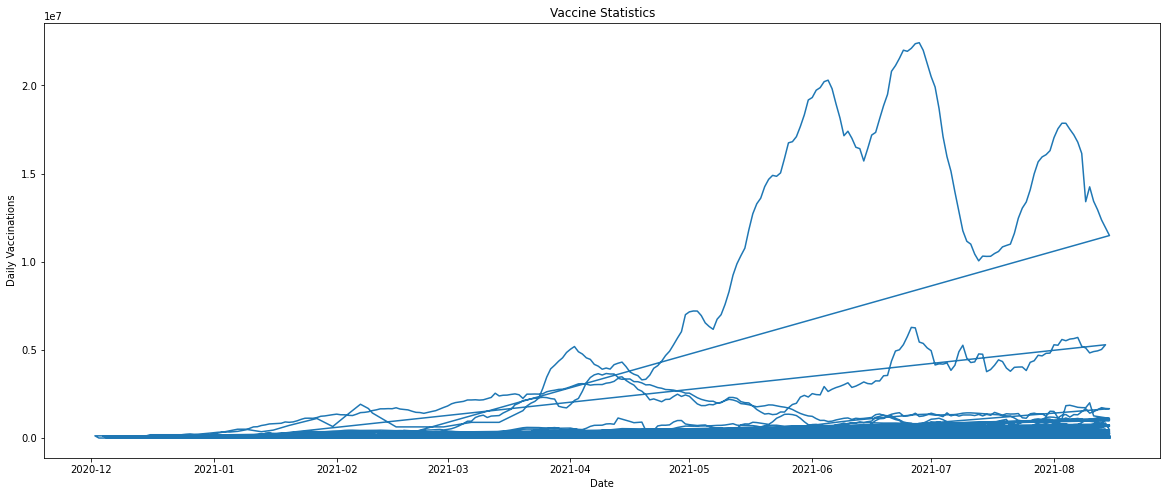

In [19]:
plt.figure(figsize=(20,8))
plt.plot(delhifinal)
plt.title('Vaccine Statistics')
plt.xlabel('Date')
plt.ylabel('Daily Vaccinations')
plt.show()

In [20]:
date = df['date'].values
daily = df['daily_vaccinations'].values


In [21]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

#Split

In [22]:
x_train, x_test, y_train, y_test = train_test_split(date, daily, test_size = 0.2, random_state = 0 , shuffle=False)
print(len(x_train), len(x_test))

30221 7556


#Membangun Model menggunakan Model Sequential

In [23]:
scaler = MinMaxScaler()
train_scale = scaler.fit_transform(x_train.reshape(-1, 1))
test_scale = scaler.fit_transform(x_test.reshape(-1, 1))
look_back = 20
train_gen = TimeseriesGenerator(train_scale, train_scale, length=look_back, batch_size=20)
test_gen = TimeseriesGenerator(test_scale, test_scale, length=look_back, batch_size=1)
model = tf.keras.Sequential([
  tf.keras.layers.Conv1D(filters=312, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(120),
  tf.keras.layers.Dense(60, activation="softmax"),
  tf.keras.layers.Dense(20, activation="softmax"),
  tf.keras.layers.Dense(2),
  tf.keras.layers.Lambda(lambda x: x * 40)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 312)         1872      
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         225792    
_________________________________________________________________
lstm_1 (LSTM)                (None, 120)               119520    
_________________________________________________________________
dense (Dense)                (None, 60)                7260      
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 42        
_________________________________________________________________
lambda (Lambda)              (None, 2)                 0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [24]:
max = df['daily_vaccinations'].max()
print('Max value : ' )
print(max)

Max value : 
22424286.0


In [25]:
min = df['daily_vaccinations'].min()
print('Min Value : ')
print(min)

Min Value : 
0.0


In [26]:
x = (1722328.0 - 0.0) * (10 / 100)
print(x)

172232.80000000002


#Implementasi Callback Apabila memenuhi Standar Akurasi yang Sudah Ditentukan

In [27]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92 and logs.get('mae')<x):
      self.model.stop_training = True
      print("\nAkurasi pada training set dan validation set di atas 90% dan MAE < 10%")
callbacks = myCallback()

#Pelatihan Model

In [28]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["accuracy", "mae"])
history = model.fit(train_gen, epochs=3, validation_data=test_gen, verbose=1, callbacks=[callbacks])

Epoch 1/3
1511/1511 [==============================] - 100s 64ms/step - loss: 0.8054 - accuracy: 1.0000 - mae: 1.2601 - val_loss: 0.7615 - val_accuracy: 1.0000 - val_mae: 1.2083

Akurasi pada training set dan validation set di atas 90% dan MAE < 10%


#Grafik MAE

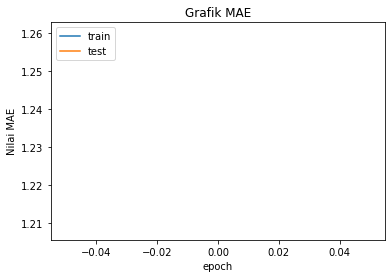

In [29]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Grafik MAE')
plt.ylabel('Nilai MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Grafik Akurasi

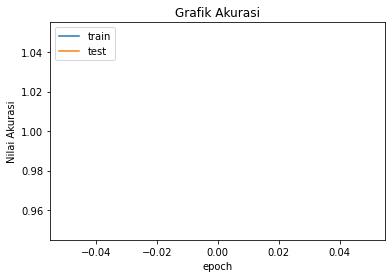

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Grafik Akurasi')
plt.ylabel('Nilai Akurasi')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Grafik Loss

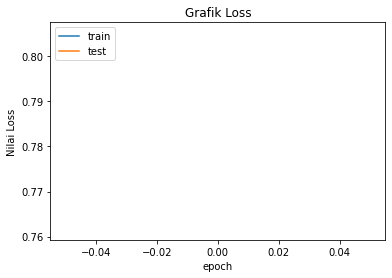

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Grafik Loss')
plt.ylabel('Nilai Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()